# Mean-variance optimization

In this cookbook recipe, we work on several examples demonstrating PyPortfolioOpt's mean-variance capabilities. I will discuss what I think should be your "default" options, based on my experience in optimising portfolios.

To start, you need a list of tickers. Some people just provide the whole universe of stocks, but I don't think this is a good idea - portfolio optimization is quite different from asset selection. I would suggest anywhere from 10-50 stocks as a starting point.

Some of the things we cover:

- Downloading data and getting it into PyPortfolioOpt
- Calculating and visualising the covariance matrix
- Optimising a long/short portfolio to minimise total variance
- Optimising a portfolio to maximise the Sharpe ratio, subject to sector constraints
- Optimising a portfolio to maximise return for a given risk, subject to sector constraints, with an L2 regularisation objective
- Optimising a market-neutral portfolio to minimise risk for a given level of return
- Optimising along the mean-semivariance frontier
- Optimising along the mean-CVaR frontier
- Plotting the efficient frontier:
    - Simple (using CLA)
    - Constrained
    - Complex plots

Please consult the [docs](https://pyportfolioopt.readthedocs.io/) for more info.

## Downloading data

To download data, we will use `yfinance`, an excellent library that provides free price data from Yahoo Finance, no API key needed.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb)

In [42]:
# pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

In [43]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [44]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA"] 

In [45]:
ohlc = yf.download(tickers, period="max")

[*********************100%%**********************]  15 of 15 completed


In [46]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.tail()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
2023-09-18,315.880005,139.979996,562.719971,85.019997,12.34,75.620003,149.119995,58.299999,29.080000,417.130005,329.059998,33.639999,265.279999,486.059998,117.639999
2023-09-19,317.329987,137.630005,564.349976,81.940002,12.56,75.769997,148.929993,58.180000,28.910000,413.529999,328.649994,33.990002,266.500000,480.660004,117.330002
2023-09-20,316.799988,135.289993,563.830017,82.559998,12.36,75.820000,148.300003,58.439999,28.520000,410.519989,320.769989,33.619999,262.589996,492.130005,116.400002
2023-09-21,312.000000,129.330002,555.080017,82.730003,12.20,75.269997,147.139999,57.540001,28.280001,403.359985,319.529999,32.849998,255.699997,501.140015,114.760002
2023-09-22,316.089996,129.119995,558.590027,81.250000,12.43,75.010002,145.729996,57.599998,28.049999,402.220001,317.010010,32.689999,244.880005,506.100006,114.940002


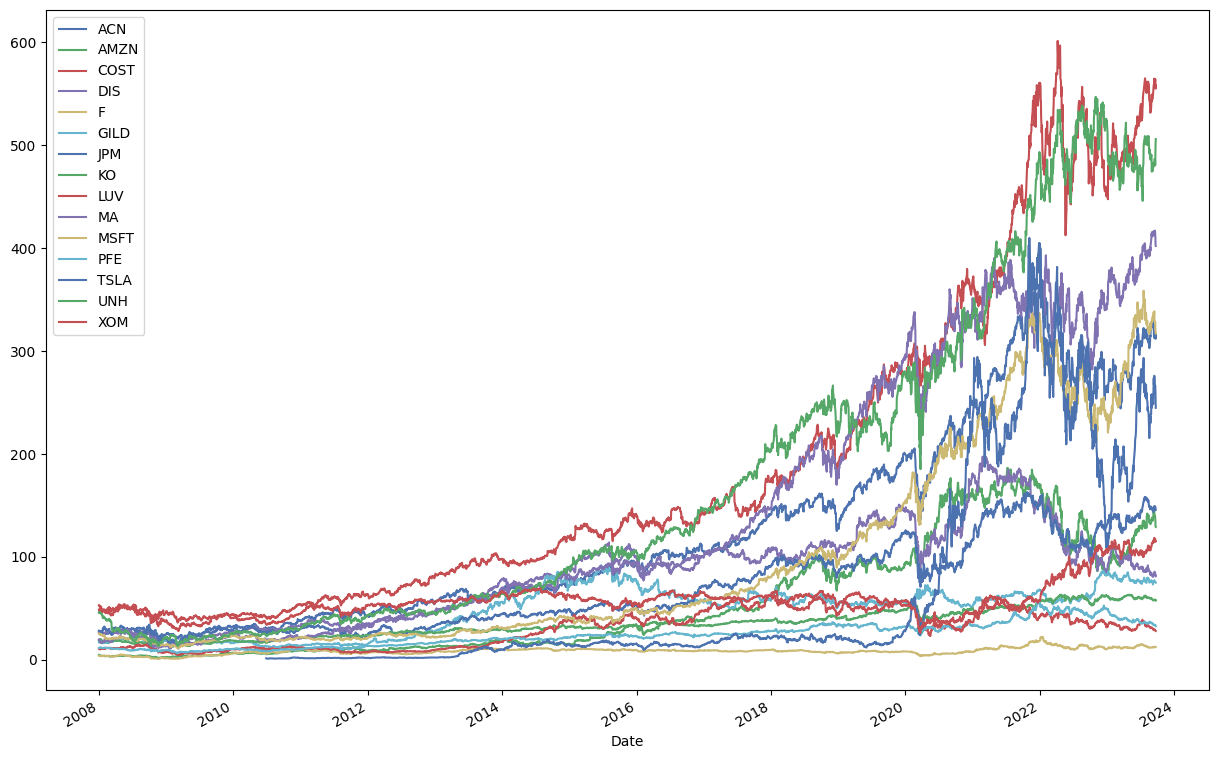

In [47]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

<Axes: xlabel='Date'>

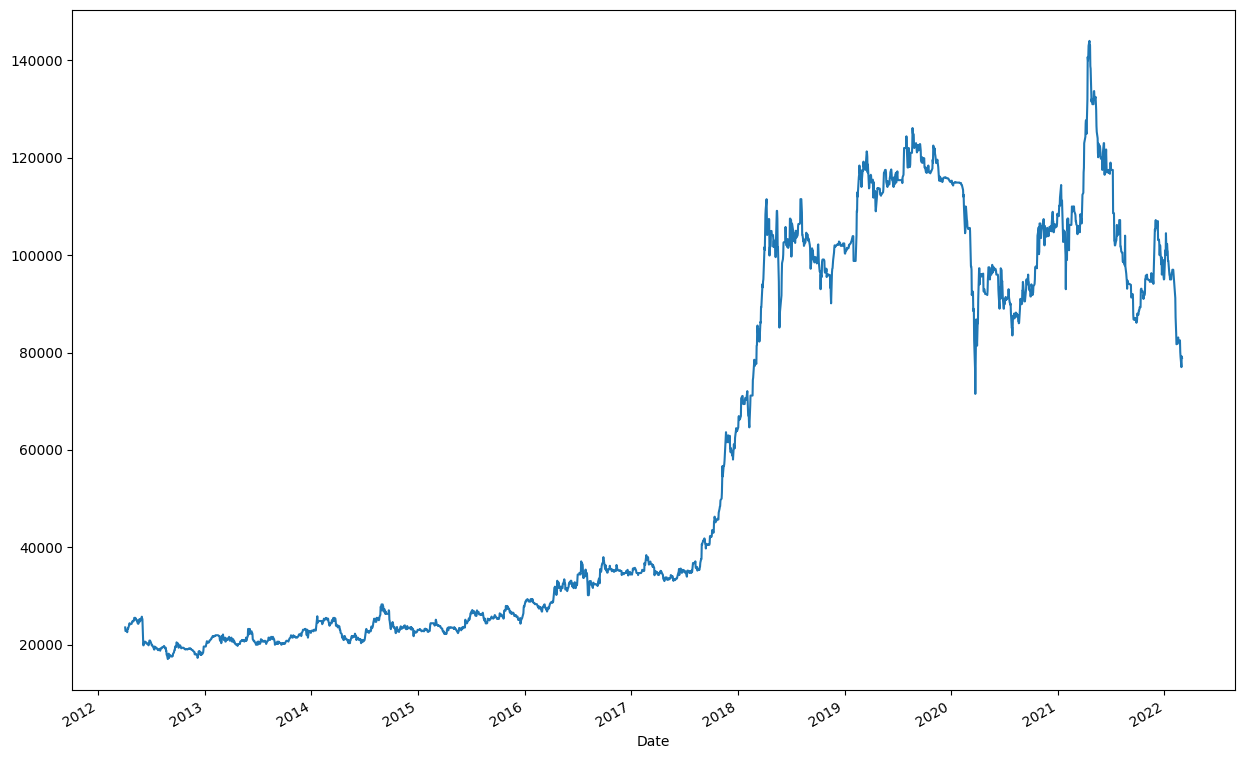

In [22]:
prices_sp[prices_sp.index >= '2008-01-01'].plot(figsize=(15, 10))

## Calculating the covariance matrix

In [48]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [49]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
ACN,0.089959,0.046615,0.028287,0.041067,0.044459,0.028342,0.047567,0.020326,0.036798,0.045710,0.042100,0.025496,0.044264,0.029705,0.029737
AMZN,0.046615,0.324255,0.047701,0.055946,0.053328,0.056526,0.064728,0.019955,0.047416,0.056079,0.072806,0.030643,0.066751,0.033689,0.026265
COST,0.028287,0.047701,0.100018,0.031725,0.031684,0.026638,0.037939,0.021187,0.030869,0.031920,0.037221,0.024954,0.029474,0.027104,0.020113
DIS,0.041067,0.055946,0.031725,0.099602,0.041390,0.031691,0.046896,0.025929,0.039773,0.050089,0.042808,0.029051,0.043958,0.031382,0.025668
F,0.044459,0.053328,0.031684,0.041390,0.127677,0.029670,0.054389,0.026077,0.046990,0.061308,0.041592,0.026885,0.059375,0.028655,0.028179
GILD,0.028342,0.056526,0.026638,0.031691,0.029670,0.227638,0.041621,0.016627,0.030489,0.031379,0.034545,0.032142,0.030873,0.033318,0.020800
JPM,0.047567,0.064728,0.037939,0.046896,0.054389,0.041621,0.126519,0.027413,0.048684,0.067086,0.048465,0.032303,0.040975,0.037950,0.032993
KO,0.020326,0.019955,0.021187,0.025929,0.026077,0.016627,0.027413,0.053054,0.022648,0.025544,0.027436,0.025752,0.018105,0.022725,0.020448
LUV,0.036798,0.047416,0.030869,0.039773,0.046990,0.030489,0.048684,0.022648,0.137808,0.047548,0.036539,0.025614,0.042895,0.031735,0.023284
MA,0.045710,0.056079,0.031920,0.050089,0.061308,0.031379,0.067086,0.025544,0.047548,0.114320,0.048822,0.031137,0.048685,0.040949,0.040616


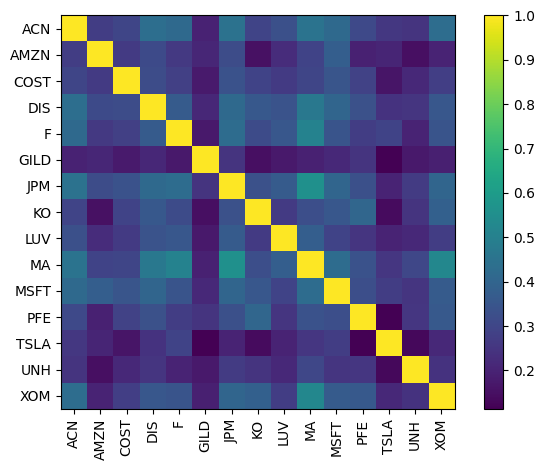

In [50]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

# Exercise 1
* a. Using https://pyportfolioopt.readthedocs.io/en/latest/Plotting.html, state the difference between plot_correlation=True and plot_correlation=False when we use the function plotting.plot_covariance() 
* b. Using the above plot, explain why the elements on the main diagonal has higher values than the off-diagonal elements?

<Axes: >

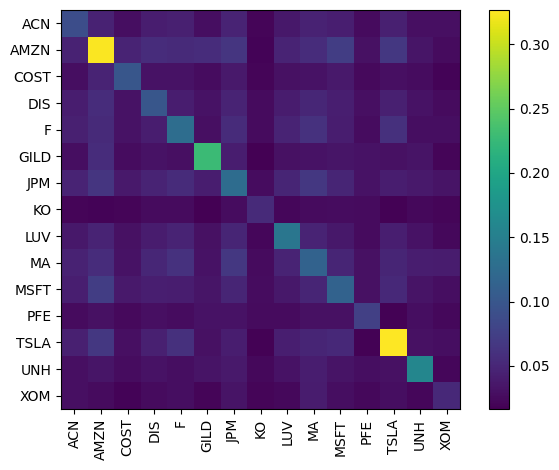

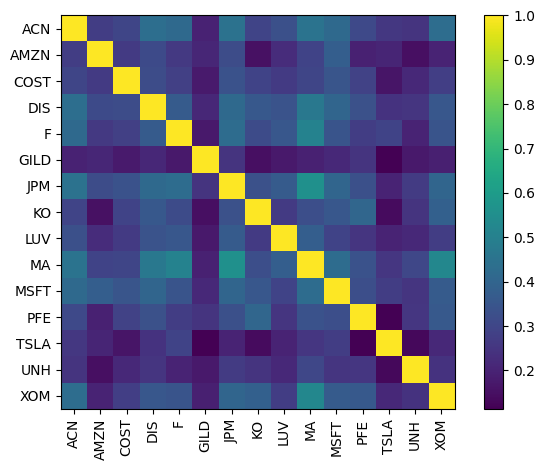

In [51]:
# Your answers go here
pypfopt.plotting.plot_covariance(sample_cov, plot_correlation=False, show_tickers=True)
pypfopt.plotting.plot_covariance(sample_cov, plot_correlation=True, show_tickers=True)

For reasons discussed in the docs, the sample covariance matrix should not be your default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal:

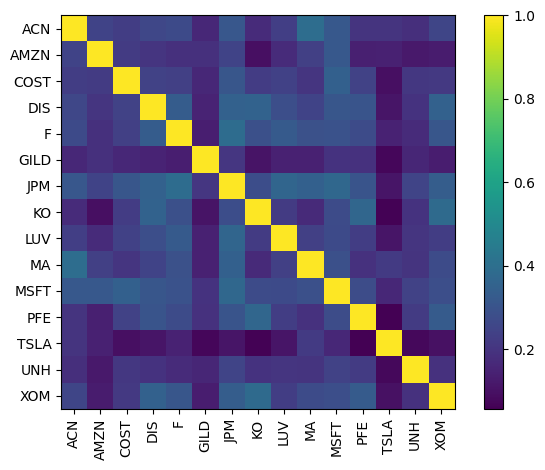

In [52]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

## Return estimation

As discussed in the docs, it is often a bad idea to provide returns using a simple estimate like the mean of past returns. Unless you have a proprietary method for estimating returns, research suggests that you may be better off not providing expected returns – you can then just find the `min_volatility()` portfolio or use `HRP`. 

However, in this example we will use the CAPM returns, which aims to be slightly more stable than the default mean historical return. Please see the notebook `Lab3_Risk_Return_Models.ipynb` for more information.

In [53]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)
mu

ACN     0.205377
AMZN    0.345047
COST    0.189379
DIS     0.219204
F       0.221666
GILD    0.242109
JPM     0.243881
KO      0.143965
LUV     0.221910
MA      0.250870
MSFT    0.233172
PFE     0.172514
TSLA    0.291081
UNH     0.211507
XOM     0.138378
Name: mkt, dtype: float64

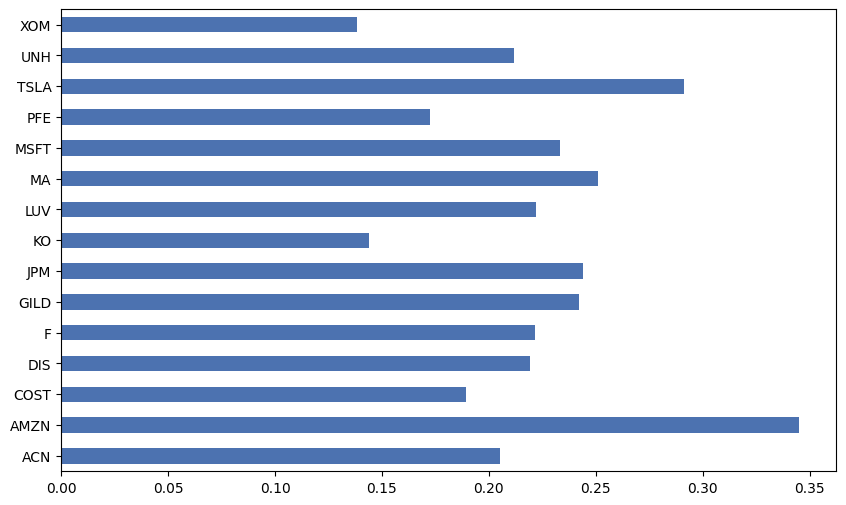

In [54]:
mu.plot.barh(figsize=(10,6));

## Long/short min variance

In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios.

In [55]:
from pypfopt import EfficientFrontier

In [56]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.22791),
             ('AMZN', 0.00614),
             ('COST', 0.10018),
             ('DIS', -0.02061),
             ('F', -0.02291),
             ('GILD', 0.0494),
             ('JPM', -0.04677),
             ('KO', 0.13575),
             ('LUV', 0.02454),
             ('MA', 0.2361),
             ('MSFT', -0.00244),
             ('PFE', 0.07168),
             ('TSLA', 0.11999),
             ('UNH', 0.03595),
             ('XOM', 0.0851)])

In [57]:
a = [w[1] for w in weights.items()]
sum(a)

1.00001

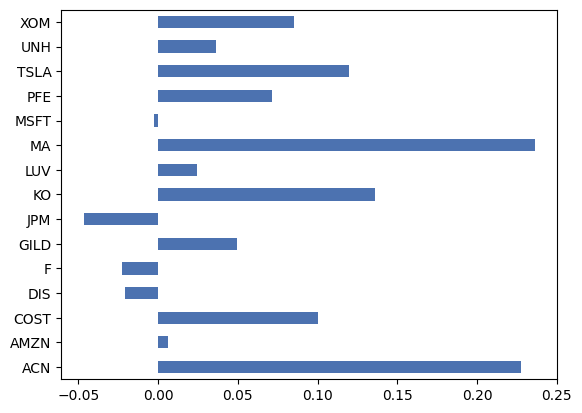

In [58]:
pd.Series(weights).plot.barh();

We can get a quick indication of the portfolio performance as follows. Note that this is an in sample estimate and may have very little resemblance to how the portfolio actually performs!

# Exercise 2
* a. Write a function `computeSum()` to take an OrderedDict object (same as the variable `weights` above) and return the sum of all the weights.
* b. Use the function `computeSum()` you implemented in Part (a) to calculate the sum of all the weights in the variable `weights`
* c. What do the signs of the weights (`+` and `-`) mean for the portfolio?
* d. Write a funciton `computePosNeg()` to take an OrderedDict object (same as the variable `weights` above) and return the sum of all the positive weights and the sum of all the negative weights.


In [59]:
# Your code and answers go here

# a. Write a function `computeSum()` 

def computeSum(od):
    
    list_weights = [w[1] for w in od.items()]
    
    s = sum(list_weights)
    
    return s


def computePosNeg(od):
    
    list_pos = [w[1] for w in od.items() if w[1] > 0]
    pos_s = sum(list_pos)

    list_neg = [w[1] for w in od.items() if w[1] < 0]
    neg_s = sum(list_neg)
        
    return pos_s, neg_s

    



In [60]:
computeSum(weights)

1.00001

In [61]:
computePosNeg(weights)

(1.09274, -0.09273)

In [62]:
ef.portfolio_performance(verbose=True);

Annual volatility: 12.2%


In [63]:
prices

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,0.058398,NaN,NaN,NaN,0.048528,NaN,NaN,NaN,NaN,NaN,NaN,0.096660
1962-01-03,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.047447,NaN,NaN,NaN,NaN,NaN,NaN,0.098095
1962-01-04,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.047807,NaN,NaN,NaN,NaN,NaN,NaN,0.098335
1962-01-05,NaN,NaN,NaN,0.059378,NaN,NaN,NaN,0.046726,NaN,NaN,NaN,NaN,NaN,NaN,0.096181
1962-01-08,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.046246,NaN,NaN,NaN,NaN,NaN,NaN,0.095942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,315.880005,139.979996,562.719971,85.019997,12.34,75.620003,149.119995,58.299999,29.080000,417.130005,329.059998,33.639999,265.279999,486.059998,117.639999
2023-09-19,317.329987,137.630005,564.349976,81.940002,12.56,75.769997,148.929993,58.180000,28.910000,413.529999,328.649994,33.990002,266.500000,480.660004,117.330002
2023-09-20,316.799988,135.289993,563.830017,82.559998,12.36,75.820000,148.300003,58.439999,28.520000,410.519989,320.769989,33.619999,262.589996,492.130005,116.400002


Let's say we were happy with this portfolio and wanted to actually go out and buy the shares.  To do this, we would need to construct a **discrete allocation** (unless your broker supports fractional shares!)

If we had \$20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows:

In [64]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

c:\Users\Dung03\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Discrete allocation performed with $369.52 leftover


c:\Users\Dung03\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'ACN': 13,
 'AMZN': 1,
 'COST': 3,
 'GILD': 12,
 'KO': 43,
 'LUV': 16,
 'MA': 11,
 'PFE': 40,
 'TSLA': 9,
 'UNH': 1,
 'XOM': 14,
 'DIS': -16,
 'F': -119,
 'JPM': -21}

In [65]:
latest_prices

ACN     316.089996
AMZN    129.119995
COST    558.590027
DIS      81.250000
F        12.430000
GILD     75.010002
JPM     145.729996
KO       57.599998
LUV      28.049999
MA      402.220001
MSFT    317.010010
PFE      32.689999
TSLA    244.880005
UNH     506.100006
XOM     114.940002
Name: 2023-09-22 00:00:00, dtype: float64

In [66]:
type(latest_prices)

pandas.core.series.Series

In [67]:
latest_prices["ACN"]

316.0899963378906

In [68]:
for ticker in latest_prices.index:
    print(ticker)

ACN
AMZN
COST
DIS
F
GILD
JPM
KO
LUV
MA
MSFT
PFE
TSLA
UNH
XOM


# Excercise 3

* a. Verify that the value of the portfolio at the time of allocation is equal to $(20,000-86.19)

In [69]:
alloc

{'ACN': 13,
 'AMZN': 1,
 'COST': 3,
 'GILD': 12,
 'KO': 43,
 'LUV': 16,
 'MA': 11,
 'PFE': 40,
 'TSLA': 9,
 'UNH': 1,
 'XOM': 14,
 'DIS': -16,
 'F': -119,
 'JPM': -21}

In [70]:
def calcPortValue(latest_prices, alloc):
    
    port_value = 0
    for ticker in alloc.keys():
        port_value += latest_prices[ticker]*alloc[ticker]
        print(ticker, latest_prices[ticker], alloc[ticker], port_value)

    return port_value    
        
    

In [71]:
calcPortValue(latest_prices, alloc)

ACN 316.0899963378906 13 4109.169952392578
AMZN 129.1199951171875 1 4238.289947509766
COST 558.5900268554688 3 5914.060028076172
GILD 75.01000213623047 12 6814.1800537109375
KO 57.599998474121094 43 9290.979988098145
LUV 28.049999237060547 16 9739.779975891113
MA 402.2200012207031 11 14164.199989318848
PFE 32.689998626708984 40 15471.799934387207
TSLA 244.8800048828125 9 17675.71997833252
UNH 506.1000061035156 1 18181.819984436035
XOM 114.94000244140625 14 19790.980018615723
DIS 81.25 -16 18490.980018615723
F 12.430000305175781 -119 17011.809982299805
JPM 145.72999572753906 -21 13951.480072021484


13951.480072021484

## Max Sharpe with sector constraints

If you have your own model for returns (or have read the warnings and want to proceed anyways), you may consider maximising the Sharpe ratio. This theoretically gives the optimal portfolio in terms of risks-returns.

In this section, we construct a long-only max-sharpe portfolio, but also incorporate sector constraints. Sector constraints require three things. A `sector_mapper`, your `sector_lower` bounds, and your `sector_upper` bounds.

In [72]:
sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto"
}

sector_lower = {
    "Consumer Staples": 0.1, # at least 10% to staples
    "Tech": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Tech": 0.2,
    "Aerospace":0.1,
    "Energy": 0.1,
    "Auto":0.15
}

We then set up the optimizer and add our constraints. We can use `ef.add_objective()` to add other constraints. For example, let's say that in addition to the above sector constraints, I specifically want:

- 10% of the portfolio in AMZN
- Less than 5% of my portfolio in TSLA

In [73]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

amzn_index = ef.tickers.index("AMZN")
ef.add_constraint(lambda w: w[amzn_index] == 0.10)

tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.05)

ef.add_constraint(lambda w: w[10] >= 0.05)

ef.max_sharpe()
weights = ef.clean_weights()

In [74]:
weights

OrderedDict([('ACN', 0.16859),
             ('AMZN', 0.1),
             ('COST', 0.05424),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.06473),
             ('JPM', 0.0),
             ('KO', 0.04576),
             ('LUV', 0.0236),
             ('MA', 0.37679),
             ('MSFT', 0.05),
             ('PFE', 0.02904),
             ('TSLA', 0.05),
             ('UNH', 0.03725),
             ('XOM', 0.0)])

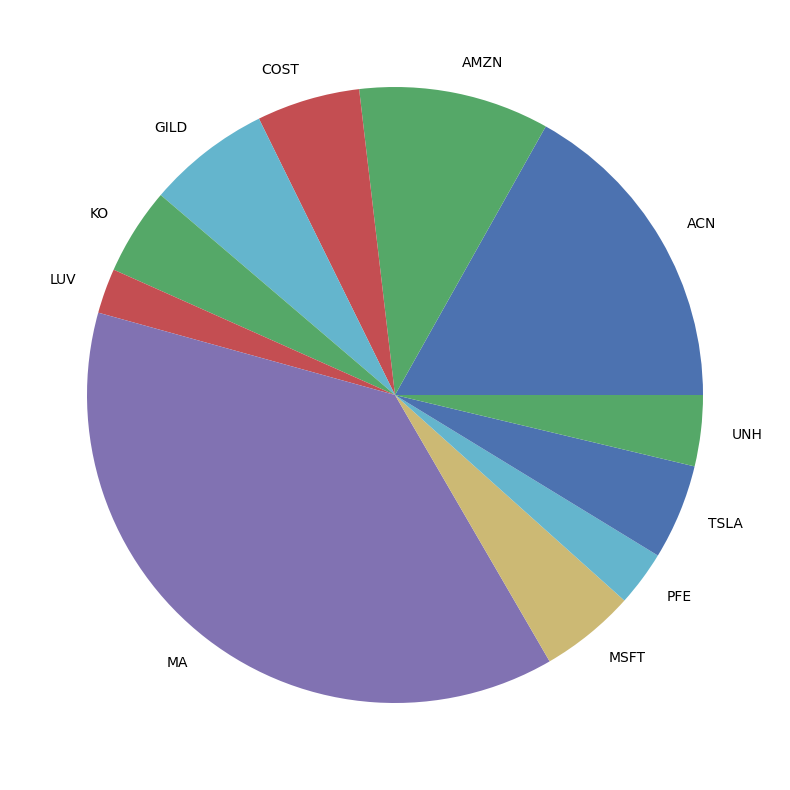

In [75]:
pd.Series(weights).plot.pie(figsize=(10,10));

We can immediately see that our explicit constraints were satisfied, and can check all the sector constraints as follows:


In [76]:
# O(N^2) loop not a good idea in a coding interview :)
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Healthcare: 0.131
Tech: 0.050
Auto: 0.050
Energy: 0.000
Aerospace: 0.024
Misc: 0.169
Financial Services: 0.377
Consumer Discretionary: 0.100
Media: 0.000
Consumer Staples: 0.100


## Maximise return for a given risk, with L2 regularisation

Let's imagine that we've put a lot of thought into our risk tolerance, and have decided that we can't accept anything more than 15% volatility. We can use PyPortfolioOpt to construct a portfolio that maximises return for a given risk (with the same caveats about expected returns).

In [77]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.01011),
             ('AMZN', 0.16552),
             ('COST', 0.09338),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.06671),
             ('JPM', 0.0),
             ('KO', 0.00662),
             ('LUV', 0.00836),
             ('MA', 0.43437),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.01494),
             ('XOM', 0.0)])

In [78]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

5/15 tickers have zero weight


In [79]:
ef.portfolio_performance(verbose=True);

Expected annual return: 26.3%
Annual volatility: 15.0%
Sharpe Ratio: 1.62


While this portfolio seems like it meets our objectives, we might be worried by the fact that a lot of the tickers have been assigned zero weight. In effect, the optimizer is "overfitting" to the data you have provided -- you are much more likely to get better results by enforcing some level of diversification. One way of doing this is to use **L2 regularisation** – essentially, adding a penalty on the number of near-zero weights.

In [80]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamma is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.06888),
             ('AMZN', 0.18471),
             ('COST', 0.0828),
             ('DIS', 0.0178),
             ('F', 0.0),
             ('GILD', 0.07924),
             ('JPM', 0.04494),
             ('KO', 0.0172),
             ('LUV', 0.03498),
             ('MA', 0.23124),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.03821),
             ('XOM', 0.0)])

In [81]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

3/15 tickers have zero weight


We can tune the value of gamma to choose the number of nonzero tickers. Larger gamma pulls portfolio weights towards an equal allocation.

In [82]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=1)  # gamma is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.05908),
             ('AMZN', 0.12614),
             ('COST', 0.0611),
             ('DIS', 0.06429),
             ('F', 0.05681),
             ('GILD', 0.07626),
             ('JPM', 0.07631),
             ('KO', 0.0389),
             ('LUV', 0.06588),
             ('MA', 0.08178),
             ('MSFT', 0.07156),
             ('PFE', 0.04218),
             ('TSLA', 0.09319),
             ('UNH', 0.06121),
             ('XOM', 0.02533)])

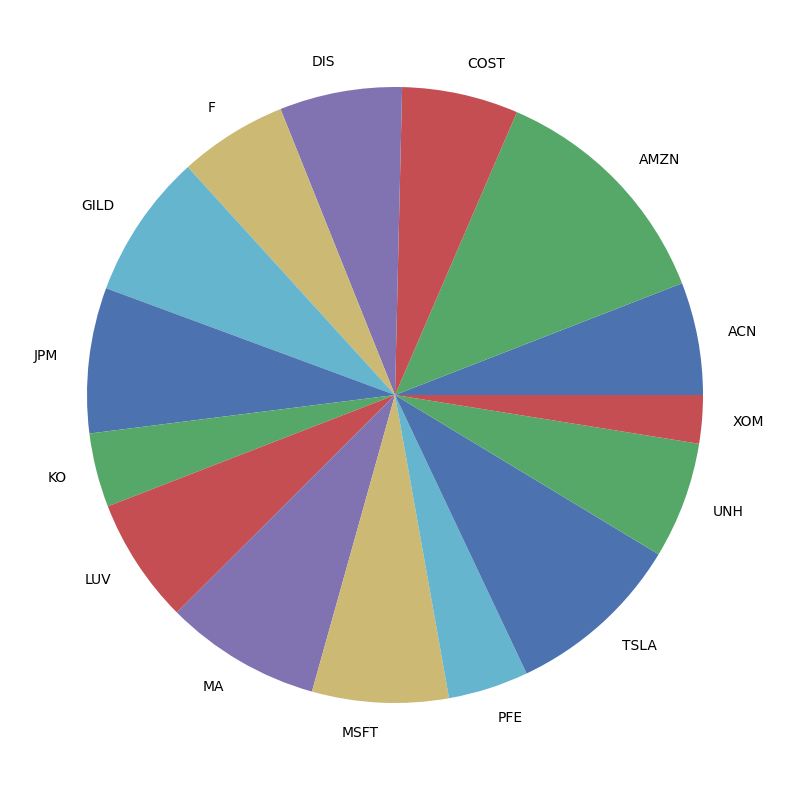

In [83]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [84]:
ef.portfolio_performance(verbose=True);

Expected annual return: 23.9%
Annual volatility: 15.0%
Sharpe Ratio: 1.46


The resulting portfolio still has a volatility of less than our 15% limit. It's in-sample Sharpe ratio has gone down, but this portfolio is a lot more robust for actual investment.

## Minimise risk for a given return, market-neutral

We may instead be in the situation where we have a certain required rate of return (maybe we are a pension fund that needs 7% return a year), but would like to minimise risk. Additionally, suppose we would like our portfolio to be market neutral, in the sense that it is equally exposed to the long and short sides.  

In [85]:
# Must have no weight bounds to allow shorts
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_objective(objective_functions.L2_reg)
ef.efficient_return(target_return=0.07, market_neutral=True)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', -0.03276),
             ('AMZN', 0.21566),
             ('COST', -0.06108),
             ('DIS', -0.00162),
             ('F', 0.00141),
             ('GILD', 0.03522),
             ('JPM', 0.04232),
             ('KO', -0.14277),
             ('LUV', 0.00101),
             ('MA', 0.05546),
             ('MSFT', 0.02042),
             ('PFE', -0.08874),
             ('TSLA', 0.12728),
             ('UNH', -0.01687),
             ('XOM', -0.15494)])

In [86]:
ef.portfolio_performance(verbose=True);

Expected annual return: 7.0%
Annual volatility: 10.8%
Sharpe Ratio: 0.46


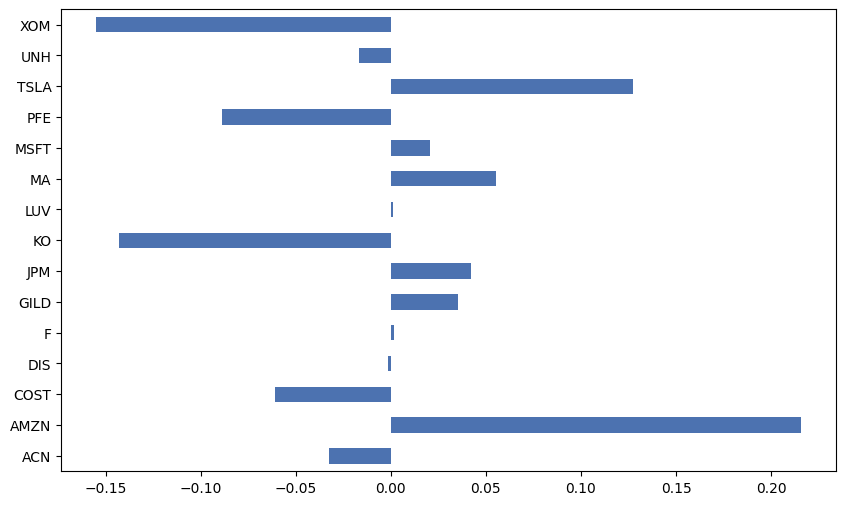

In [87]:
pd.Series(weights).plot.barh(figsize=(10,6));

In [88]:
print(f"Net weight: {sum(weights.values()):.2f}")

Net weight: 0.00


## Efficient semi-variance optimization

In this example, we will minimise the portfolio semivariance (i.e downside volatility) subject to a return constraint (target 20%).

There are actually two ways of doing this in PyPortfolioOpt. The first is the "intuitive" way. We compute a semicovariance matrix, and pass this into `EfficientFrontier` (just like we would do for the exponential cov matrix or the Ledoit-Wolf shrunk matrix).

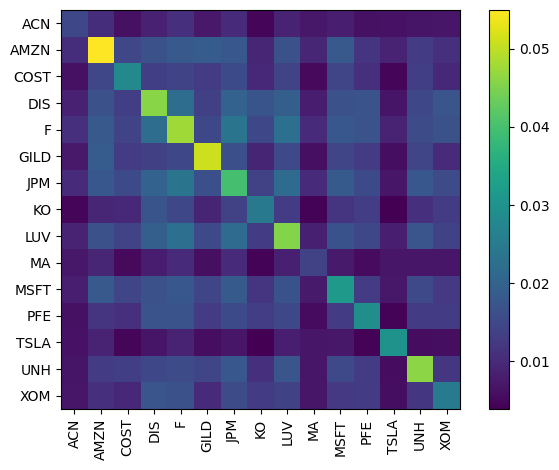

In [89]:
semicov = risk_models.semicovariance(prices, benchmark=0)
plotting.plot_covariance(semicov);

In [90]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.2)
weights = ef.clean_weights()
weights


OrderedDict([('ACN', 0.2524),
             ('AMZN', 0.0),
             ('COST', 0.08608),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.01678),
             ('JPM', 0.0),
             ('KO', 0.14732),
             ('LUV', 0.0),
             ('MA', 0.32187),
             ('MSFT', 0.0),
             ('PFE', 0.04976),
             ('TSLA', 0.1087),
             ('UNH', 0.0027),
             ('XOM', 0.01439)])

In [91]:
ef.portfolio_performance(verbose=True);

Expected annual return: 21.7%
Annual volatility: 9.3%
Sharpe Ratio: 2.13


However, this solution is not truly optimal in mean-semivariance space. To do the optimization properly, we must use the `EfficientSemivariance` class. This requires us to first compute the returns and drop NaNs.

In [92]:
returns = expected_returns.returns_from_prices(prices)
returns = returns.dropna()

In [93]:
from pypfopt import EfficientSemivariance

es = EfficientSemivariance(mu, returns)
es.efficient_return(0.2)
es.portfolio_performance(verbose=True);


Expected annual return: 20.0%
Annual semi-deviation: 10.6%
Sortino Ratio: 1.70


To compare this with the heuristic solution, I will use a quick hack: replacing the `es.weights` with `es.weights` and running `es.portfolio_performance` again. Please don't be encouraged to do this in real life!

In [94]:
es.weights = ef.weights
es.portfolio_performance(verbose=True);

Expected annual return: 21.7%
Annual semi-deviation: 13.8%
Sortino Ratio: 1.43


We see that the heuristic method has a significantly lower Sortino ratio, and much higher semivariance.

## Efficient CVaR optimization

In this example, we will find the portfolio that maximises return subject to a CVaR constraint.

Before doing this, let's first compute the 95%-CVaR for the max-sharpe portfolio.

In [95]:
returns = expected_returns.returns_from_prices(prices).dropna()
returns.head()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
2010-06-30,0.000000,0.005985,-0.014381,-0.024768,0.020243,-0.019731,-0.012142,-0.004173,0.000000,-0.017045,-0.012871,-0.001401,-0.002511,-0.008034,-0.003840
2010-07-01,-0.009573,0.015559,0.001277,-0.000317,0.048611,-0.004084,-0.013129,-0.001795,-0.010802,0.016651,0.006519,-0.002104,-0.078473,-0.019366,-0.008060
2010-07-02,-0.008882,-0.016402,-0.012204,-0.003493,-0.027436,0.021382,-0.006929,0.000400,-0.021838,0.000346,0.004750,-0.006325,-0.125683,0.016158,-0.000707
2010-07-06,0.012388,0.008430,-0.004241,0.010835,-0.011673,-0.002868,0.013955,0.007592,-0.011163,-0.013513,0.023635,0.010608,-0.160937,0.020848,0.015733
2010-07-07,0.022130,0.030620,0.005370,0.044767,0.042323,0.004889,0.050096,0.020623,0.062089,0.037695,0.020151,0.023093,-0.019243,0.010730,0.016881


In [96]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 24.7%
Annual volatility: 13.4%
Sharpe Ratio: 1.70


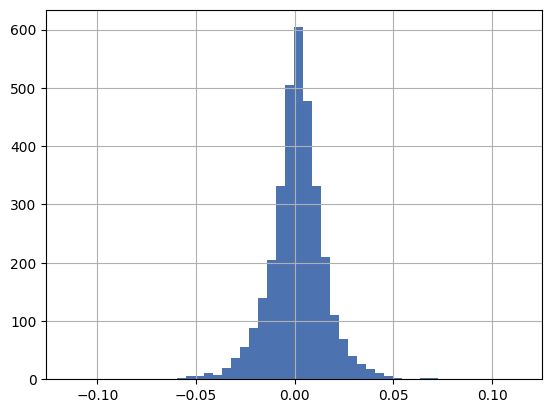

In [97]:
# Compute CVaR
portfolio_rets = (returns * weight_arr).sum(axis=1)
portfolio_rets.hist(bins=50);

In [98]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -2.22%
CVaR: -3.29%


This value of the CVaR means that our average loss on the worst 5% of days will be -3.35%. Let's say that this were beyond our comfort zone (for a \\$100,000 portfolio, this would mean losing \\$3350 in a day).

Let's firstly construct the portfolio with the minimum CVaR:

In [99]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True);

Expected annual return: 17.2%
Conditional Value at Risk: 2.14%


We have significantly reduced the CVaR, but at the cost of a large reduction in returns. We can use `efficient_risk` to maximise the return for a target risk. Let's say that a 2.5% CVaR is acceptable.

In [100]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.025)
ec.portfolio_performance(verbose=True);

Expected annual return: 23.3%
Conditional Value at Risk: 2.50%


We now have similar returns to before (24.7% vs 25.8%), but with a lower tail risk (2.50% CVaR vs 3.35%). 

## Plotting - Unconstrained

To plot the unconstrained efficient frontier, it is easiest to use the critical line algorithm. 

In [101]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 24.4%
Annual volatility: 13.2%
Sharpe Ratio: 1.70


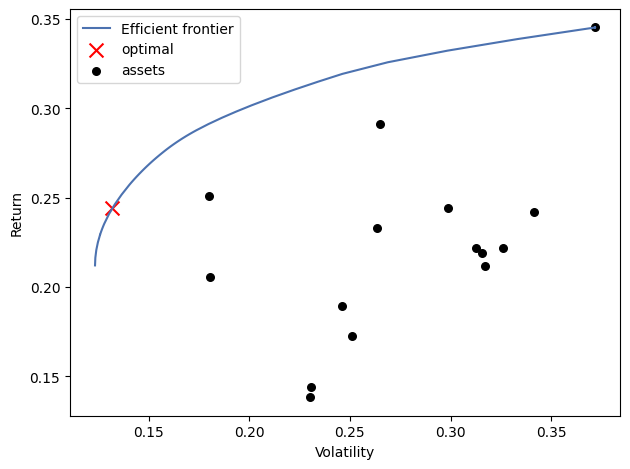

In [102]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

## Plotting - Constrained

In this example, we will plot the efficient frontier corresponding to portfolios with a constraint on exposure to MSFT, AMZN, and TSLA (e.g maybe we want to avoid big tech).

In [115]:
import cvxpy as cp

mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S,)
big_tech_indices = [t in {"MSFT", "AMZN", "TSLA"} for t in tickers]
ef.add_constraint(lambda w: cp.sum(w[big_tech_indices]) <= 0.3)

As per the docs, *before* we call any optimization function, we should pass this to the plotting module:

In [ ]:
ax = plotting.plot_efficient_frontier(ef, ef_param="risk", 
                                      ef_param_range=np.linspace(0.12, 0.4, 50), 
                                      showfig=False);

## Complex plots

The `plotting` module allows you to pass in an `ax`, on top of which the plots are added. This allows you to build complex plots. 

In this example, we will plot the efficient frontier as well as 10,000 simulated portfolios. 

To generate the simulated portfolios, we will sample random weights from the Dirichlet distribution (these are already normalised):

In [108]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.21727699 0.19868717 0.21237479 ... 0.22012883 0.23301028 0.21616903]
Sample portfolio volatilities: 0       0.172835
1       0.151512
2       0.173297
3       0.153260
4       0.152374
          ...   
9995    0.161403
9996    0.150359
9997    0.145907
9998    0.170874
9999    0.150694
Length: 10000, dtype: float64


Note that the above code is equivalent to generating samples via a for loop (just more efficient)

In [109]:
# mus = []
# stds = []
# sharpes = []
# for _ in range(10000):
#     w = np.random.dirichlet(np.ones(len(mu)))
#     # w = np.random.rand(len(mu))
#     # w /= w.sum()
#     ret = mu.dot(w)
#     std = np.sqrt(w.dot(S @ w))
#     mus.append(ret)
#     stds.append(std)
#     sharpes.append(ret / std)

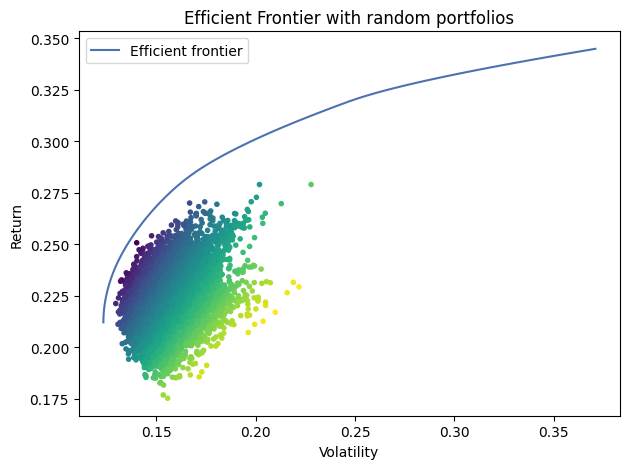

In [110]:
# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
